# LightGCN

## Import libraries

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from typing import Dict

from torch import nn, optim, Tensor, torch
from torch_geometric.utils.num_nodes import maybe_num_nodes

In [2]:
from data_loaders.data_loader_lightgcn import UserUserDatasetLightGCN
from light_gcn.light_gcn import LightGCN, bpr_loss, get_user_positive_items, RecallPrecision_ATk, NDCGatK_r, get_metrics, evaluation

In [3]:
torch.__version__

'2.1.1+cu118'

In [4]:
torch.device('cuda')

device(type='cuda')

In [5]:
print(torch.cuda.is_available()) 

True


## Import data

In [6]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

datasets_dict = {
    "postings": postings,
    "votes": votes
}

## Create a UserUserDataset object for LightGCN model

In [7]:
uu_dataset_lightgcn = UserUserDatasetLightGCN(datasets_dict = datasets_dict, verbose = True)

In [ ]:
train_edge_index, val_edge_index, test_edge_index = uu_dataset_lightgcn.get_train_test_val_split(val_split_ratio = 0.2, test_split_ratio = 0.5, random_state = 1, sparse = False)

Train edge index shape:  torch.Size([2, 716156])
Val edge index shape:  torch.Size([2, 89520])
Test edge index shape:  torch.Size([2, 89520])


In [ ]:
source, target, negative_target = uu_dataset_lightgcn.get_negative_samples(train_edge_index)

In [ ]:
user_indices, pos_item_indices, neg_item_indices = uu_dataset_lightgcn.get_random_mini_batches(512)

# LightGCN: Run training loop

In [ ]:
num_users, num_articles = uu_dataset_lightgcn.num_users, uu_dataset_lightgcn.num_articles
model = LightGCN(num_users, num_articles)

In [ ]:
ITERATIONS = 2000
BATCH_SIZE = 64 * 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [13]:
# setup
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = uu_dataset_lightgcn.edge_index.to(device)

train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = uu_dataset_lightgcn.train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = uu_dataset_lightgcn.val_sparse_edge_index.to(device)

Using device cuda.


In [14]:
# training loop
train_losses = []
val_losses = []
recall_list = []
precision_list = []
ndcg_list = []
hits_list = []

for iter in tqdm(range(ITERATIONS)):

    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = uu_dataset_lightgcn.get_random_mini_batches(BATCH_SIZE)

    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg, hits = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}, val_hits@{K}: {round(hits, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        recall_list.append(recall)
        precision_list.append(precision)
        ndcg_list.append(ndcg)
        hits_list.append(hits)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

33703


  0%|          | 3/2000 [00:53<7:38:24, 13.77s/it] 

[Iteration 0/2000] train_loss: -0.56726, val_loss: -0.52362, val_recall@20: 0.00467, val_precision@20: 0.00116, val_ndcg@20: 0.00256, val_hits@20: 0.0113


 10%|▉         | 199/2000 [01:12<02:54, 10.33it/s]

33703


 10%|█         | 203/2000 [02:04<2:45:02,  5.51s/it]

[Iteration 200/2000] train_loss: -3.86438, val_loss: -0.53937, val_recall@20: 0.05004, val_precision@20: 0.01201, val_ndcg@20: 0.02682, val_hits@20: 0.11886


 20%|█▉        | 399/2000 [02:24<02:37, 10.15it/s]  

33703


 20%|██        | 403/2000 [03:17<2:32:57,  5.75s/it]

[Iteration 400/2000] train_loss: -16.56464, val_loss: -0.88574, val_recall@20: 0.05341, val_precision@20: 0.01289, val_ndcg@20: 0.02774, val_hits@20: 0.12263


 30%|██▉       | 599/2000 [03:36<02:17, 10.16it/s]  

33703


 30%|███       | 603/2000 [04:29<2:10:17,  5.60s/it]

[Iteration 600/2000] train_loss: -35.31868, val_loss: -1.56129, val_recall@20: 0.05472, val_precision@20: 0.01313, val_ndcg@20: 0.02808, val_hits@20: 0.12388


 40%|████      | 800/2000 [04:49<01:57, 10.24it/s]  

33703


 40%|████      | 803/2000 [05:43<2:15:09,  6.77s/it]

[Iteration 800/2000] train_loss: -58.78853, val_loss: -2.41599, val_recall@20: 0.05682, val_precision@20: 0.01367, val_ndcg@20: 0.03039, val_hits@20: 0.12953


 50%|█████     | 1000/2000 [06:03<01:40, 10.00it/s] 

33703


 50%|█████     | 1003/2000 [06:57<1:46:27,  6.41s/it]

[Iteration 1000/2000] train_loss: -84.72172, val_loss: -3.39265, val_recall@20: 0.05912, val_precision@20: 0.01392, val_ndcg@20: 0.03204, val_hits@20: 0.13524


 60%|██████    | 1200/2000 [07:17<01:36,  8.32it/s]  

33703


 60%|██████    | 1203/2000 [08:11<1:54:59,  8.66s/it]

[Iteration 1200/2000] train_loss: -113.48421, val_loss: -4.4501, val_recall@20: 0.05994, val_precision@20: 0.01413, val_ndcg@20: 0.0329, val_hits@20: 0.14042


 70%|███████   | 1400/2000 [08:31<00:57, 10.38it/s]  

33703


 70%|███████   | 1403/2000 [09:23<1:02:04,  6.24s/it]

[Iteration 1400/2000] train_loss: -143.24269, val_loss: -5.402, val_recall@20: 0.06207, val_precision@20: 0.01462, val_ndcg@20: 0.03394, val_hits@20: 0.14398


 80%|████████  | 1600/2000 [09:44<00:39, 10.19it/s]  

33703


 80%|████████  | 1603/2000 [10:37<42:03,  6.36s/it]  

[Iteration 1600/2000] train_loss: -175.15379, val_loss: -6.50373, val_recall@20: 0.06349, val_precision@20: 0.01485, val_ndcg@20: 0.03446, val_hits@20: 0.14377


 90%|█████████ | 1800/2000 [10:57<00:19, 10.03it/s]

33703


 90%|█████████ | 1803/2000 [11:52<21:29,  6.55s/it]

[Iteration 1800/2000] train_loss: -206.65463, val_loss: -7.67016, val_recall@20: 0.0659, val_precision@20: 0.01541, val_ndcg@20: 0.0354, val_hits@20: 0.1479


100%|██████████| 2000/2000 [12:12<00:00,  2.73it/s]


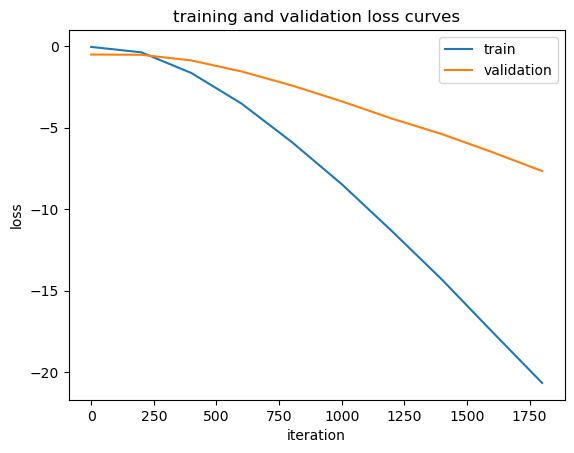

In [15]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, np.array(train_losses)/10, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

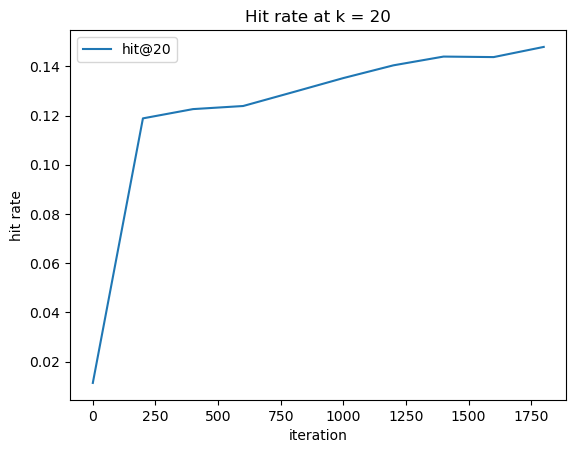

In [19]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
# plt.plot(iters, np.array(train_losses)/10, label='train')
plt.title('Hit rate at k = 20')
plt.plot(iters, hits_list, label='hit@20')
plt.xlabel('iteration')
plt.ylabel('hit rate')

plt.legend()
plt.show()

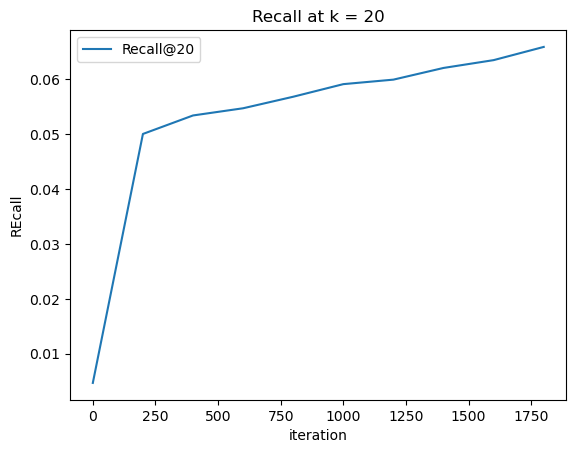

In [20]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
# plt.plot(iters, np.array(train_losses)/10, label='train')
plt.title('Recall at k = 20')
plt.plot(iters, recall_list, label='Recall@20')
plt.xlabel('iteration')
plt.ylabel('REcall')

plt.legend()
plt.show()